$$
\mathrm{P\&L}
=\Bigg[
\underbrace{\,t\,\overline{\Gamma^{*}}\;\frac{\sigma_{r}+\sigma_{0}}{2}\,(\sigma_{r}-\sigma_{0})\,}_{\text{Volatility premium component}}
\;+\;
\underbrace{\frac{t}{2}\,\rho\;\mathrm{Stdev}\!\big(\Gamma^{*}\big)\;
\mathrm{Stdev}\!\left(\frac{d\langle S\rangle}{S^{2}\,du}\right)}_{\text{Gamma covariance effect}}
\;+\;
\underbrace{e^{-rt}\,\frac{\sigma+\sigma_{0}}{2\sigma}\;
\frac{\partial P}{\partial \sigma}(t)\;(\sigma-\sigma_{0})}_{\text{Vega term}}
\;-\;
\underbrace{\int_{0}^{t}\frac{T-u}{2}\,\big(\sigma^{2}-\sigma_{0}^{2}\big)\,d\Gamma_{u}^{*}}_{\text{dGamma term}}
\;-\;
\underbrace{\int_{0}^{t}\frac{e^{-ru}}{2}\left(\frac{\nu}{\sigma}\,\frac{\partial \nu}{\partial \sigma}\right)\,d\langle\sigma\rangle_{u}}_{\text{Residual drift term}}
\Bigg],
$$


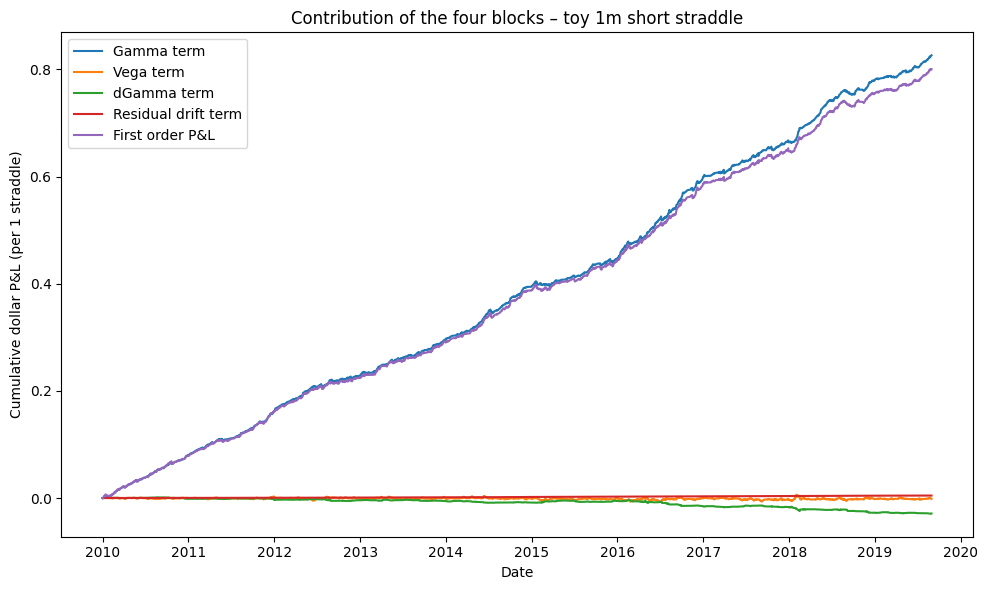

            Gamma term  Vega term  dGamma term  Residual drift term  \
2019-08-19    0.821048  -0.001286    -0.028600             0.004620   
2019-08-20    0.822381  -0.000274    -0.028758             0.004620   
2019-08-21    0.821388   0.000279    -0.028931             0.004620   
2019-08-22    0.822784   0.000458    -0.029017             0.004620   
2019-08-23    0.824432   0.000287    -0.029221             0.004620   
2019-08-26    0.823813   0.000141    -0.029407             0.004620   
2019-08-27    0.824690  -0.000566    -0.029050             0.004622   
2019-08-28    0.825120  -0.001310    -0.028777             0.004625   
2019-08-29    0.826169  -0.001504    -0.028888             0.004626   
2019-08-30    0.826390  -0.001752    -0.028831             0.004626   

            First order P&L  
2019-08-19         0.795782  
2019-08-20         0.797970  
2019-08-21         0.797357  
2019-08-22         0.798845  
2019-08-23         0.800119  
2019-08-26         0.799168  
2019-08-

In [2]:
# Short (o long) 1M delta-hedged straddle – P&L attribution “alla Figura 2”
# Componenti: Gamma, Vega, dGamma, Residual drift, e First-order (somma).
# Toy model con S_t GBM e volatilità stocastica (log-OU). Black–Scholes per i greeks.

import numpy as np
import pandas as pd
from math import erf
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

# =========================
# Parametri principali
# =========================
position = -1.0      # -1 = short straddle, +1 = long straddle
n_years   = 10
trading_days = 252
n   = n_years * trading_days
dt  = 1.0 / trading_days
r   = 0.0            # tasso risk-free
q   = 0.0            # dividend/foreign rate (FX)

# Volatilità stocastica: log-OU
kappa     = 4.0      # mean reversion speed (ann.)
sigma_bar = 0.09     # vol di lungo periodo
vol_of_vol = 0.50    # vol-of-vol su log sigma
S0 = 1.20

# Premium di volatilità: implied = realized + bias (per avere VRP positivo)
vrp_bias = 0.02
rho_sv   = -0.2      # correlazione shock spot/vol (FX tipicamente modesta)

# =========================
# Simulazione S_t e sigma_t
# =========================
log_sigma = np.log(sigma_bar) * np.ones(n+1)
sigma = np.empty(n+1); sigma[0] = sigma_bar
S = np.empty(n+1);     S[0] = S0

for t in range(1, n+1):
    z1, z2 = rng.standard_normal(2)
    eps_s = z1
    eps_v = rho_sv * z1 + np.sqrt(1 - rho_sv**2) * z2
    # log-sigma OU
    log_sigma[t] = (log_sigma[t-1]
                    + kappa * (np.log(sigma_bar) - log_sigma[t-1]) * dt
                    + vol_of_vol * np.sqrt(dt) * eps_v)
    sigma[t] = np.exp(log_sigma[t])
    # GBM
    S[t] = S[t-1] * np.exp((r - q - 0.5 * sigma[t-1]**2) * dt + sigma[t-1] * np.sqrt(dt) * eps_s)

# implied (traded)
sigma_imp = np.maximum(1e-4, sigma + vrp_bias)

# =========================
# Black–Scholes greeks (call); straddle = 2*call
# =========================
def norm_pdf(x): return (1.0/np.sqrt(2.0*np.pi))*np.exp(-0.5*x*x)
def bs_d1(S, K, r, q, sigma, tau):
    if sigma * np.sqrt(tau) < 1e-10: return np.sign(np.log(S/K))*np.inf
    return (np.log(S/K) + (r - q + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
def bs_gamma(S, K, r, q, sigma, tau):
    if tau<=0 or sigma<=0: return 0.0
    d1 = bs_d1(S,K,r,q,sigma,tau); return np.exp(-q*tau)*norm_pdf(d1)/(S*sigma*np.sqrt(tau))
def bs_vega(S, K, r, q, sigma, tau):
    if tau<=0 or sigma<=0: return 0.0
    d1 = bs_d1(S,K,r,q,sigma,tau); return S*np.exp(-q*tau)*norm_pdf(d1)*np.sqrt(tau)
def bs_volga(S, K, r, q, sigma, tau):
    if tau<=0 or sigma<=0: return 0.0
    d1 = bs_d1(S,K,r,q,sigma,tau); d2 = d1 - sigma*np.sqrt(tau)
    vega = bs_vega(S,K,r,q,sigma,tau); return vega * d1 * d2 / sigma

# =========================
# Rollover straddle 1M (21 gg)
# =========================
roll_days = 21
K = S[0]
t_enter = 0
tau_days = roll_days

gamma_term = np.zeros(n+1)
vega_term  = np.zeros(n+1)   # cumulata di ΔF_t
dgamma_term = np.zeros(n+1)
residual_term = np.zeros(n+1)
first_order = np.zeros(n+1)

Gamma_star_prev = None
F_prev = 0.0
sigma0_trade = sigma_imp[0]

for t in range(1, n+1):
    # roll mensile
    if tau_days <= 0:
        K = S[t-1]
        t_enter = t-1
        tau_days = roll_days
        sigma0_trade = sigma_imp[t-1]
        F_prev = 0.0
        Gamma_star_prev = None

    tau = tau_days * dt

    # greeks straddle = 2*calls ATM
    gamma_call = bs_gamma(S[t-1], K, r, q, sigma_imp[t-1], tau)
    vega_call  = bs_vega (S[t-1], K, r, q, sigma_imp[t-1], tau)
    volga_call = bs_volga(S[t-1], K, r, q, sigma_imp[t-1], tau)
    gamma_straddle = 2.0 * gamma_call
    vega_straddle  = 2.0 * vega_call
    volga_straddle = 2.0 * volga_call

    # Γ* = e^{-rt} S^2 Gamma
    Gamma_star = np.exp(-r * tau) * (S[t-1]**2) * gamma_straddle

    # ritorno spot
    r_t = (S[t] - S[t-1]) / S[t-1]

    # ---- Gamma term (discreto) ----
    gamma_inc = position * (0.5 * Gamma_star * ((r_t**2 / dt) - sigma0_trade**2) * dt)
    gamma_term[t] = gamma_term[t-1] + gamma_inc

    # ---- Vega term: ΔF_t con F_t che “netta” a ~0 su vita ----
    F_t = ((sigma_imp[t-1] + sigma0_trade) / (2.0 * sigma_imp[t-1])) * vega_straddle * (sigma_imp[t-1] - sigma0_trade)
    vega_term[t] = vega_term[t-1] + position * (F_t - F_prev)
    F_prev = F_t

    # ---- dGamma term ----
    dGamma_star = 0.0 if (Gamma_star_prev is None) else (Gamma_star - Gamma_star_prev)
    u = (t - t_enter) * dt
    dgamma_inc = position * ( - (tau/2.0) * (sigma_imp[t-1]**2 - sigma0_trade**2) * dGamma_star )
    dgamma_term[t] = dgamma_term[t-1] + dgamma_inc
    Gamma_star_prev = Gamma_star

    # ---- Residual drift term ----
    d_sigma = sigma_imp[t] - sigma_imp[t-1]
    res_inc = position * ( -0.5 * np.exp(-r*u) * (vega_straddle / max(sigma_imp[t-1], 1e-8)) * (volga_straddle) * (d_sigma**2) )
    residual_term[t] = residual_term[t-1] + res_inc

    # ---- First-order (somma) ----
    first_order[t] = gamma_term[t] + vega_term[t] + dgamma_term[t] + residual_term[t]

    tau_days -= 1

# =========================
# Output e grafico stile Fig. 2
# =========================
dates = pd.date_range("2010-01-01", periods=n+1, freq="B")
df = pd.DataFrame({
    "Gamma term": gamma_term,
    "Vega term": vega_term,
    "dGamma term": dgamma_term,
    "Residual drift term": residual_term,
    "First order P&L": first_order
}, index=dates)

plt.figure(figsize=(10,6))
for col in ["Gamma term", "Vega term", "dGamma term", "Residual drift term", "First order P&L"]:
    plt.plot(df.index, df[col], label=col)
plt.title("Contribution of the four blocks – toy 1m short straddle" if position<0
          else "Contribution of the four blocks – toy 1m long straddle")
plt.xlabel("Date"); plt.ylabel("Cumulative dollar P&L (per 1 straddle)")
plt.legend(loc="best")
plt.tight_layout(); plt.show()

print(df.tail(10))
